<a href="https://colab.research.google.com/github/kwasicode/Artificial-Intelligence/blob/main/gans_vehicle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import os
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Reshape, Input
from tensorflow.keras.layers import BatchNormalization
from keras.layers import UpSampling2D



# Set the path to the zip file
zip_path = '/sports_car.zip'

# Extract the contents of the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/sports_car/sports_car')

In [16]:
def load_images(directory, target_size=(256, 256)):
    image_data = []
    for filename in os.listdir(directory):
        if filename.endswith((".jpg", ".png")):
            filepath = os.path.join(directory, filename)
            image = cv2.imread(filepath)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, target_size)
            image_data.append(image)
    return np.array(image_data)

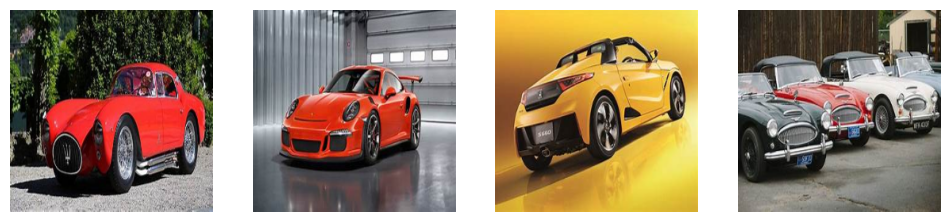

In [17]:
import random

# Load and preprocess images
dataset_path = '/content/sports_car/sports_car/sports_car'
images = load_images(dataset_path)

# Display four random sample images in a horizontal row
plt.figure(figsize=(12, 3))

for i in range(4):
    random_index = random.randint(0, len(images) - 1)
    plt.subplot(1, 4, i + 1)
    plt.imshow(images[random_index])  # Display the randomly selected image
    plt.axis('off')

plt.show()



In [18]:
# Load and preprocess images
dataset_path = '/content/sports_car/sports_car/sports_car'
images = load_images(dataset_path)
images = load_images(dataset_path, target_size=(256, 256))
# Normalize pixel values to the range [0, 1]
images = images / 255.0
print(f"Number of images in the dataset: {images.shape[0]}")


Number of images in the dataset: 176


In [32]:
# Define GAN architecture
generator = Sequential([
    Dense(32 * 32 * 128, input_shape=(100,), activation='relu'),
    Reshape((32, 32, 128)),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    UpSampling2D(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    UpSampling2D(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    UpSampling2D(),
    Conv2D(3, (3, 3), activation='sigmoid', padding='same')
])

discriminator = Sequential([
    Conv2D(64, (3, 3), input_shape=(256, 256, 3), activation='relu', padding='same'),
    Flatten(),
    Dense(1, activation='sigmoid')
])

In [37]:
# Compile the models
generator.compile(optimizer='adam', loss='binary_crossentropy')
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [38]:
discriminator.trainable = False
gan_input = Input(shape=(100,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = Model(gan_input, gan_output)
gan.compile(optimizer='adam', loss='binary_crossentropy')

In [39]:
discriminator.trainable = False
gan_input = Input(shape=(100,))
x = generator(gan_input)
print(x.shape)

(None, 256, 256, 3)


In [42]:
# Training loop (you'll need to modify this based on your specific GAN architecture and training requirements)
epochs = 100
batch_size = 128

In [43]:
# Training loop
d_loss_real_list = []  # List to store discriminator real loss values
d_loss_fake_list = []  # List to store discriminator fake loss values
d_loss = []  # List to store discriminator combined loss values
g_loss = []  # List to store generator loss values

for epoch in range(epochs):
    noise = np.random.normal(0, 1, size=(batch_size, 100))
    generated_images = generator.predict(noise)

    real_images = images[np.random.randint(0, images.shape[0], size=batch_size)]

    real_labels = 0.9 * np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    d_loss_real = discriminator.train_on_batch(real_images, real_labels)
    d_loss_fake = discriminator.train_on_batch(generated_images, fake_labels)

    # Separate and store discriminator real and fake losses
    d_loss_real_list.append(d_loss_real[0])
    d_loss_fake_list.append(d_loss_fake[0])

    # Combined discriminator loss for plotting
    d_loss_epoch = 0.5 * np.add(d_loss_real, d_loss_fake)
    d_loss.append(d_loss_epoch[0])

    noise = np.random.normal(0, 1, size=(batch_size, 100))
    valid_labels = np.ones((batch_size, 1))
    g_loss_epoch = gan.train_on_batch(noise, valid_labels)
    g_loss.append(g_loss_epoch)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{epochs} [D real loss: {d_loss_real[0]} | D real accuracy: {100 * d_loss_real[1]}] [D fake loss: {d_loss_fake[0]} | D fake accuracy: {100 * d_loss_fake[1]}] [G loss: {g_loss_epoch}]")


4/4 [==============================] - 18s 4s/step
Epoch 0/5 [D real loss: 0.7977558374404907 | D real accuracy: 0.0] [D fake loss: 0.6362088918685913 | D fake accuracy: 100.0] [G loss: 0.009813937358558178]
4/4 [==============================] - 19s 5s/step


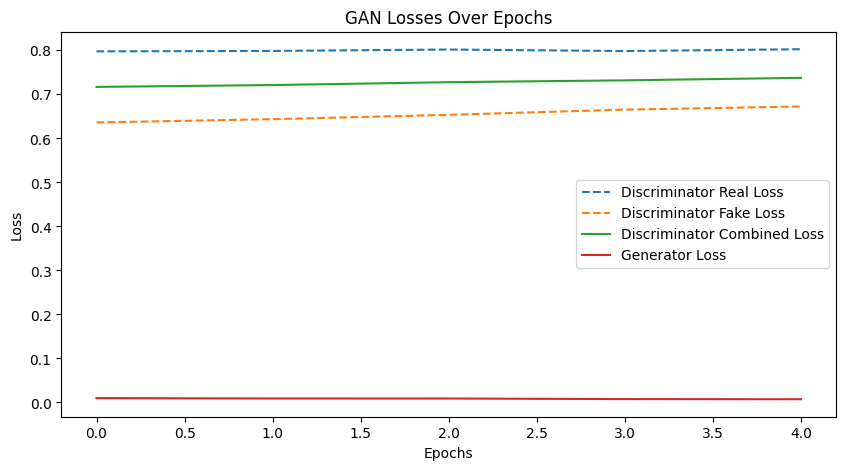

In [44]:
# Plot the losses
plt.figure(figsize=(10, 5))

# Plot Discriminator and Generator losses
plt.plot(d_loss_real_list, label='Discriminator Real Loss', linestyle='--')
plt.plot(d_loss_fake_list, label='Discriminator Fake Loss', linestyle='--')
plt.plot(d_loss, label='Discriminator Combined Loss', linestyle='-')
plt.plot(g_loss, label='Generator Loss')

# Customize the plot
plt.title('GAN Losses Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 1s 708ms/step


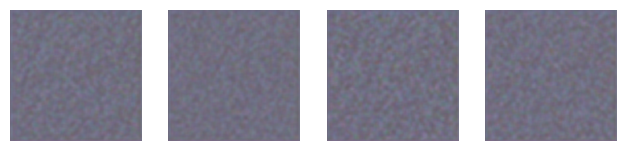

In [45]:
# Generate some sample images
generated_images = generator.predict(np.random.normal(0, 1, size=(4, 100)))

# Display generated images
plt.figure(figsize=(16, 16))
for i in range(generated_images.shape[0]):
    plt.subplot(8, 8, i+1)
    plt.imshow(generated_images[i])
    plt.axis('off')
plt.show()

In [ ]:
# Save models
generator.save('generator_model.h5')
discriminator.save('discriminator_model.h5')
